In [1]:
#setup
data_dir='../../Data/Weather'
file_index='BBBBBSBS'
m='SNWD' #Precipitation (tenths of mm)

# Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [2]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [3]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [4]:
data_dir='../../Data/Weather'
file_index='BBBBBSBS'

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
# df=df.filter(df.station=='USC00278612')
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     27.4| 43.5914| -70.2989|       SNWD|USC00177523|    12|[00 7E 00 7E 00 7...|1997.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       SNWD|USC00278612|     0|[28 5D C4 5C C4 5...|1975.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       SNWD|USC00278612|     1|[C0 5E 58 5E C0 5...|1976.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       SNWD|USC00278612|     0|[5C 5C F0 5B F0 5...|1977.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       SNWD|USC00278612|     1|[58 5E 24 5F F0 5...|1978.0|BBBBBSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Create a matrix with all of the series

In [7]:
rows=df.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()

T=np.vstack(rows)
shape(T)

(1499, 365)

### Plot two time series
`SNWD` stands for `snow-depth`, which explains why it is zero during the summer

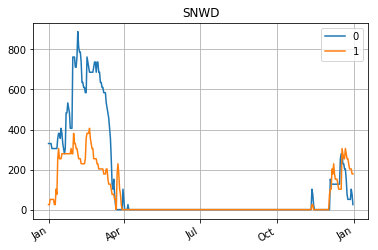

In [8]:
fig, ax = plt.subplots(figsize=(6,4));
YP=YearPlotter()
YP.plot(T[16:18].transpose(),fig,ax,title=m)

In [9]:
STAT[m]['eigvec'].shape

(365, 365)

/Users/chenzheng/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in subtract


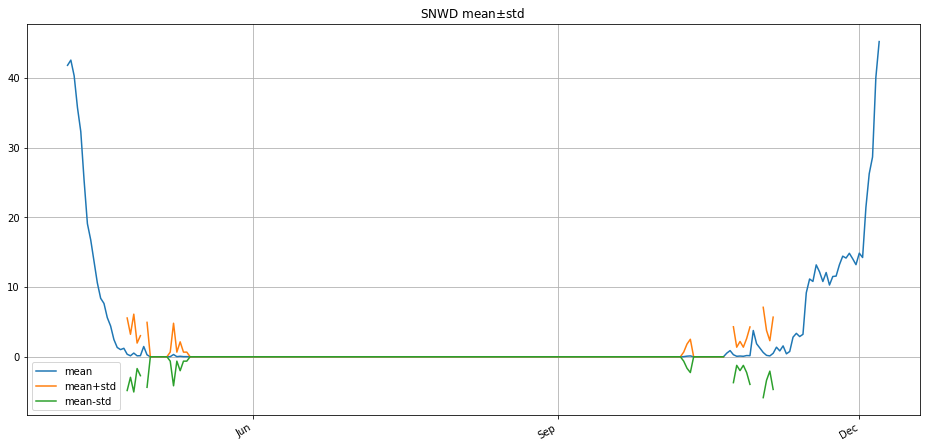

In [10]:
fig, ax = plt.subplots(figsize=(16,8));
YP=YearPlotter()
title = r'SNWD mean$\pm$std '
YP.plot(np.nanmean(T, axis=0),fig,ax,title=title, label='mean')
YP.plot(np.add(np.nanmean(T, axis=0),np.nanstd(T,axis=0)),fig,ax,label='mean+std')
YP.plot(np.subtract(np.nanmean(T, axis=0),np.nanstd(T,axis=0)),fig,ax,label='mean-std')

### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

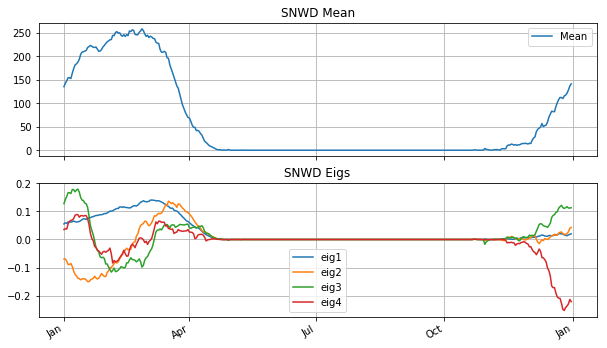

In [11]:
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=4
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

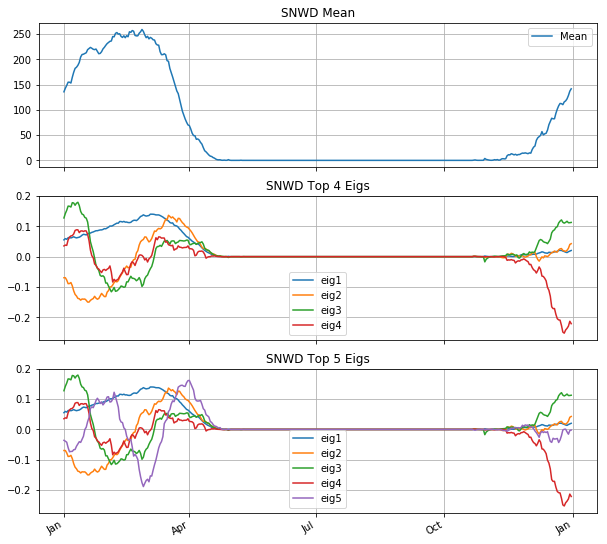

In [12]:
fig,axes=plt.subplots(3,1, sharex='col', sharey='row',figsize=(10,10));
k=4
k1 = 5
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Top 4 Eigs',labels=['eig'+str(i+1) for i in range(k)])
EigVec2=np.matrix(STAT[m]['eigvec'][:,:k1])

YearPlotter().plot(EigVec2,fig,axes[2],title=m+' Top 5 Eigs',labels=['eig'+str(i+1) for i in range(k1)])

### plot the percent of residual variance on average

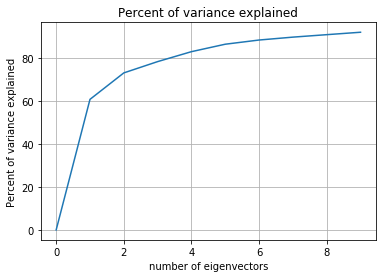

In [13]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

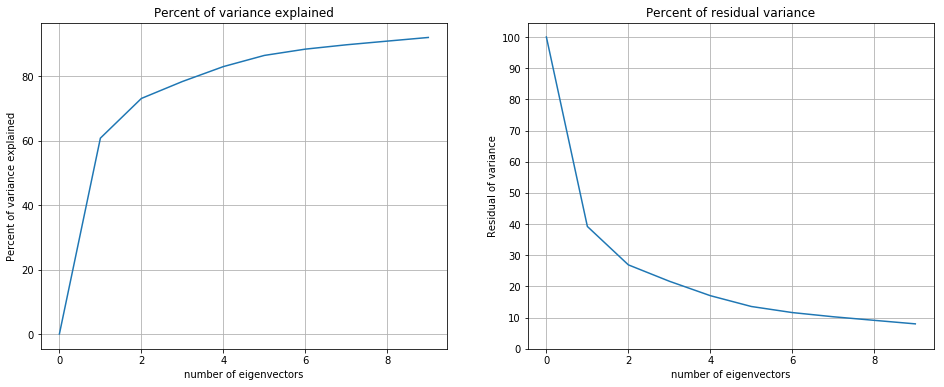

In [14]:
j = 0
fig,(ax1, ax2) = subplots(1,2,figsize=(16,6))
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax1.plot(cumvar[:10]); 
ax1.grid(); 
ax1.set_ylabel('Percent of variance explained')
ax1.set_xlabel('number of eigenvectors')
ax1.set_title('Percent of variance explained');

ax2.plot(100-cumvar[:10]); 
ax2.grid(); 
ax2.set_ylabel('Residual of variance')
ax2.set_xlabel('number of eigenvectors')
ax2.set_title('Percent of residual variance')
ax2.set_yticks(np.arange(0,110,10))

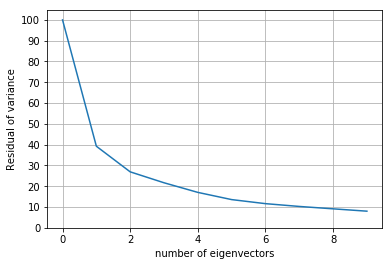

In [15]:
fig,ax=plt.subplots(1,1);
ax.plot(100-cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Residual of variance')
ax.set_xlabel('number of eigenvectors')
ax.set_yticks(np.arange(0,110,10))
# ax.y_axis.set_ticks(np.arange(0,100,10))


## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

In [16]:
i=10
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
eigen_decomp=Eigen_decomp(None,T[i],Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

residual normalized norm  after mean: 0.402922865298
residual normalized norm  after mean + top eigs: [ 0.30718989  0.24229456  0.23404426  0.1158609 ]


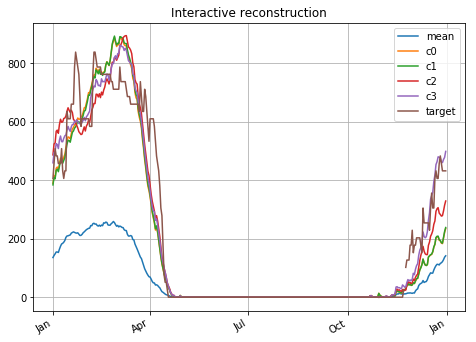

In [25]:
plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [17]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [18]:
rows=df.take(3)
L=[]
for row in rows:
    row_out=decompose(row)
    for field in ('res_mean','res_1','res_2','res_3'):
        print field,':',row_out[field],
    print

res_mean : 2.96411084025 res_1 : 0.320187764704 res_2 : 0.288464929007 res_3 : 0.287691984463
res_mean : 0.458840549987 res_1 : 0.126113908893 res_2 : 0.125516831427 res_3 : 0.124878030893
res_mean : 0.415742204578 res_1 : 0.151692131018 res_2 : 0.106717362904 res_3 : 0.0876022310977


In [19]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1499
after filter 947


In [21]:
df3=df3.sort(df3.res_3,ascending=True)
rows=df3.take(12)


In [22]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
                    %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
    return None


In [23]:
df3=df3.sort(df3.res_3)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+------------------+-------------------+--------------------+--------------------+
|          res_mean|              res_1|               res_2|               res_3|
+------------------+-------------------+--------------------+--------------------+
|0.5579571520326542|0.07586765968737774|0.025387414038319397| 0.02197298202986633|
|0.5894670461717105|0.08576687765670882| 0.02914841539208973|0.026388872550916802|
|0.6113025043190417|0.07014287198549053|0.039056233108854276|0.030136954288545008|
|0.4040682895528657| 0.2508355682120288| 0.12071761158938611| 0.03127615132485286|
+------------------+-------------------+--------------------+--------------------+
only showing top 4 rows



/Users/chenzheng/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


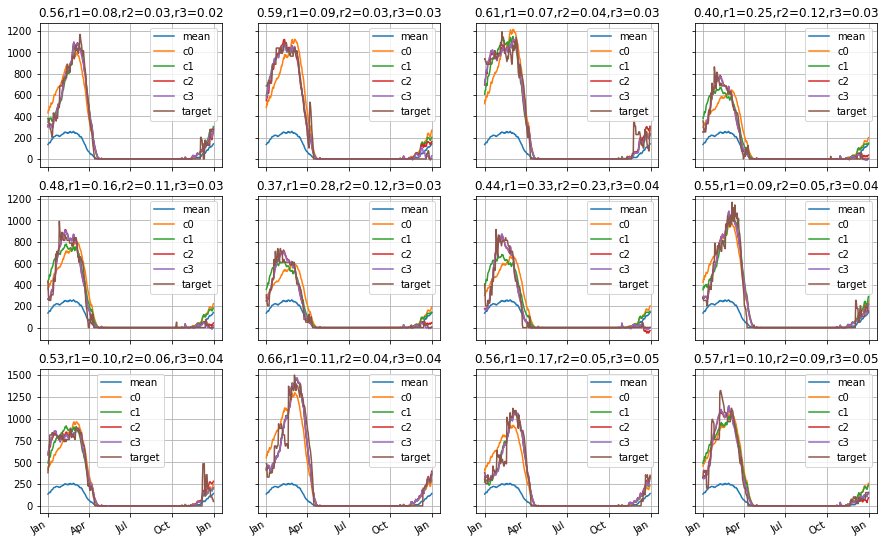

In [24]:
plot_recon_grid(rows)

In [25]:
df3=df3.sort(df3.res_3,ascending=False)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+-------------------+------------------+------------------+------------------+
|           res_mean|             res_1|             res_2|             res_3|
+-------------------+------------------+------------------+------------------+
|0.41591919057469207|1.2300767340996799| 1.242424141889937|  1.26548255911241|
|0.37991227803542305|1.2258765304105443|1.0697280217454679|1.1017879012827831|
|0.23914522225573331|0.9974786242495115|0.9964418236408664|0.9947135297378095|
| 0.4162046428672805|0.9706182550796505|1.0562636673751018|0.9919158646289167|
+-------------------+------------------+------------------+------------------+
only showing top 4 rows



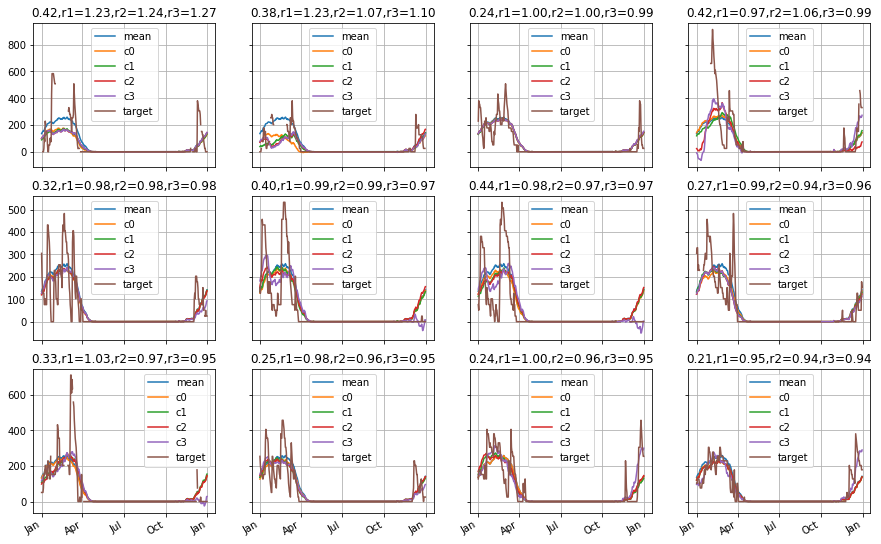

In [26]:
plot_recon_grid(rows)

### What is the distribution of the residuals and the coefficients?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [35]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
#     P=np.arange(0,1,1./(len(vals)))
    P= np.arange(0,1,1./(len(vals)))
    vals=[vals[0]]+vals
    plt.plot(vals,P)
    plt.title('cumulative distribution of '+ feat)
#     plt.title(('cumulative distribution of '+ 'res_3'))
    plt.ylabel('number of instances')
    plt.xlabel(feat)
    plt.grid()

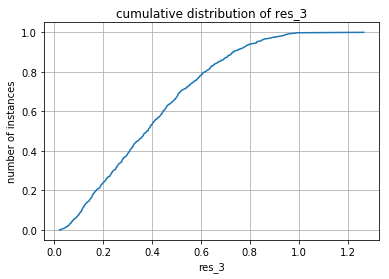

In [34]:
plot_CDF('res_3')

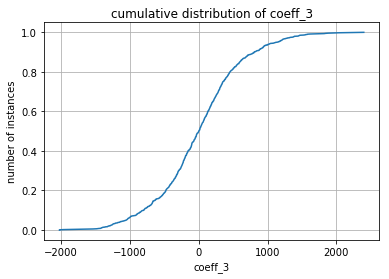

In [36]:
plot_CDF('coeff_3')

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

TypeError: 'str' object is not callable

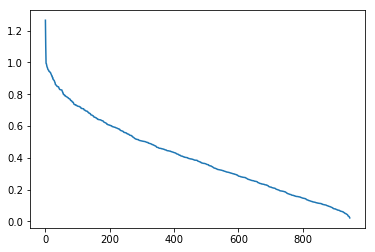

In [37]:
res3=df3.select('res_3').collect()
R3=[r['res_3'] for r in res3]
plot(R3)
title('distribution of residuals after 3 vectors')
xlabel('number of instances')
ylabel('residual')
ylim([0,1])
grid()

In [40]:
sc.stop()

In [38]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [39]:
!du -sh $data_dir/*.parquet

4.6M	../../Data/Weather/US_Weather_BBBBBSBS.parquet
4.6M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
2.5M	../../Data/Weather/decon_BBBBBSBS_SNWD.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.1M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
